In [ ]:
#%cd .. # Make sure this is the correct directory
from Former.Cpp_code.former_class_cpp import FormerGame
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.ticker import LogLocator, LogFormatter
from results.figure_functions import plot_avg_number_of_shapes, plot_branching_factor
import Former.daily_board as db

print("Imports done")

Imports done


# Notebook for analyzing *Former* boards

We analyze the following properties of randomly generated boards:
1) Distribution of shapes on daily boards
2) Branching factor

### 1. Distribution of shapes on daily boards

In [4]:
import matplotlib.pyplot as plt
import daily_board as db
import numpy as np

def plot_avg_number_of_shapes(save_path = None, show = False):
    """
    Plot average number of shapes in the Former game.
    N: number of boards to sample
    """

    # 1) Fetch all daily boards
    daily_boards = db.get_daily_board()  # {date: (board, solution, actions)}
    n_boards = len(daily_boards)

    # 2) Collect per-board shape counts
    shape_counts = []
    for _, (board, _, _) in daily_boards.items():
        # Count each shape (0–3) in this board
        unique, freq = np.unique(board, return_counts=True)
        counts = np.zeros(4, dtype=int)
        for u, f in zip(unique, freq):
            counts[int(u)] = f
        shape_counts.append(counts)

    shape_counts = np.array(shape_counts)  # shape: (n_boards, 4)

    # 3) Compute mean and standard deviation across boards
    means = shape_counts.mean(axis=0)
    stds = shape_counts.std(axis=0)

    # 4) Define colors and labels
    raw_colors = {
        0: [168,  99, 231],   # Pink
        1: [ 98, 161, 241],   # Blue
        2: [128, 194, 120],   # Green
        3: [226, 175,  92],   # Orange
    }
    colors = [tuple(c/255 for c in raw_colors[i]) for i in range(4)]
    shape_labels = ['Pink', 'Blue', 'Green', 'Orange']

    # 5) Plot mean with error bars
    fig, ax = plt.subplots(figsize=(6.5, 4))
    parts = ax.violinplot(shape_counts, showmeans=True, showmedians=False)
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(1)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.8)
        
    for key in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        artist = parts[key]
        # LineCollection has set_edgecolor, Line2D has set_color
        try:
            artist.set_edgecolor('black')
        except AttributeError:
            artist.set_color('black')
        artist.set_linewidth(1)    
    
    ax.set_xticks(np.arange(1,5))
    ax.set_xticklabels(shape_labels)
    ax.set_xlabel('Shape')
    ax.set_ylabel('Count per board')
    ax.set_title(f'Distribution of shape counts over {n_boards} daily boards')
    ax.grid(axis='y', linestyle=':', linewidth=0.5)
    ax.set_ylim(5, 28)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, format='pdf', bbox_inches='tight')
        
    if show:
        plt.show()


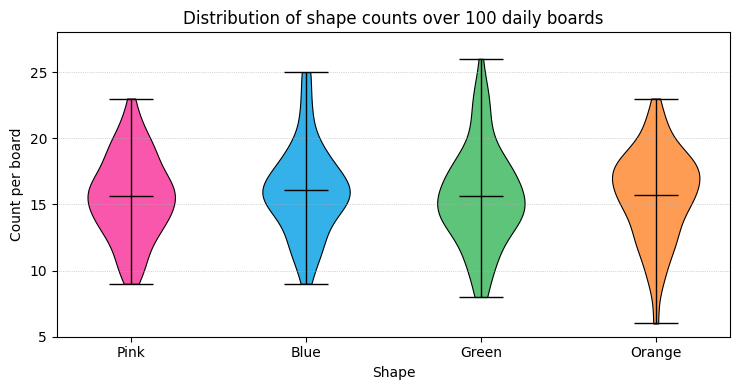

In [5]:
plot_avg_number_of_shapes(save_path='avg_shapes.pdf', show=True)

### 2. Branching factor

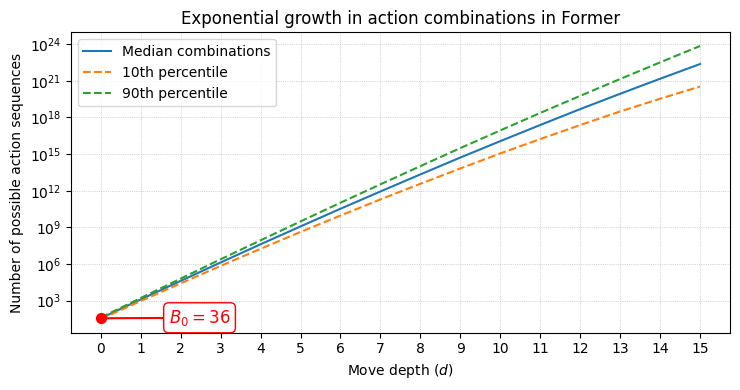

In [13]:
N = 1000
K = 16
P = 20
#boards = np.random.randint(0,4,size=(N, 9,7), dtype=np.int8)

board = np.random.randint(0, 4, size=(N, 9, 7), dtype=np.int8)

BF = {d: [] for d in range(K)}

for b in boards:
    for _ in range(P):
        state = b.copy()
        for d in range(K):
            actions = FormerGame.get_valid_turns_static(state)  
            BF[d].append(len(actions))
            if len(actions) == 0:
                for r in range(d, K):
                    BF[r].append(1)
                break
            a = random.choice(actions)
            state = FormerGame.apply_turn_static(state, a)

depths = np.arange(K)
lower = [np.percentile(BF[d], 10) for d in depths]
median = [np.percentile(BF[d], 50) for d in depths]
upper = [np.percentile(BF[d], 90) for d in depths]

cum_lower  = list(itertools.accumulate(lower, func=lambda x,y: x*y))
cum_median = list(itertools.accumulate(median, func=lambda x,y: x*y))
cum_upper  = list(itertools.accumulate(upper, func=lambda x,y: x*y))

depths = np.arange(K, dtype=int)
fig, ax = plt.subplots(figsize=(7.5, 4))

ax.plot(depths, cum_median, label='Median combinations')
ax.plot(depths, cum_lower, linestyle='--', label='10th percentile')
ax.plot(depths, cum_upper, linestyle='--', label='90th percentile')

ax.set_yscale('log')

ax.set_xticks(depths)
ax.set_xlabel(r'Move depth ($d$)')
ax.set_ylabel('Number of possible action sequences')
ax.set_title(r"Exponential growth in action combinations in Former")

# Highlight B_0
initial_d = 0
initial_val = cum_median[initial_d]
ax.scatter(initial_d, initial_val, color='red', s=50, zorder=10)
initial_val = median[0]
ax.annotate(
    r'$B_0=36$',
    xy=(0, initial_val),
    xytext=(1.7, 1.1*initial_val),
    textcoords='data',
    ha='left', va='center',
    fontsize=12,
    color='red',
    bbox=dict(
        facecolor='white',
        edgecolor='red',
        boxstyle='round,pad=0.3'
    ),
    arrowprops=dict(
        arrowstyle='-',
        color='red',
        linewidth=1.5,
        shrinkA=0, 
        shrinkB=0  
    )
)

ax.yaxis.set_major_locator(LogLocator(base=10))
ax.grid(True, which='major', linestyle=':', linewidth=0.5)
ax.grid(True, which='minor', linestyle=':', linewidth=0.2)
ax.legend()
plt.tight_layout()
plt.show()

In [19]:
import numpy as np
from collections import Counter

# -------------------------------------------------------------------
# 1) How to sample a random initial board
# -------------------------------------------------------------------

def get_moves(board: np.ndarray):
    """
    Wraps FormerGame.get_valid_turns_static.

    Input:
      board: 9×7 NumPy array of ints in {0,1,2,3}.
    Output:
      A Python list of actions, each action = (row, col) that you pass to apply_move().
    """
    # FormerGame.get_valid_turns_static expects a 9×7 NumPy array and returns a list of (r,c) tuples.
    return FormerGame.get_valid_turns_static(board)

def apply_move(board: np.ndarray, action):
    """
    Wraps FormerGame.apply_turn_static.

    Input:
      board: 9×7 NumPy array.
      action: a single (row, col) tuple indicating which group to remove.
    Output:
      A brand‐new 9×7 NumPy array after that move.
    """
    # FormerGame.apply_turn_static returns something array‐like. We convert it to np.ndarray.
    new_board = FormerGame.apply_turn_static(board, action)
    return np.array(new_board, dtype=int)

def board_to_key(board: np.ndarray):
    """
    Takes a 9×7 NumPy array (dtype=int) and returns a hashable representation.
    Here we simply use board.tobytes(), which is guaranteed to be identical
    whenever the array contents are identical.
    """
    return board.tobytes()


# -------------------------------------------------------------------
# 5) The core “two‐move‐collision” counting function
# -------------------------------------------------------------------
def count_two_move_collisions(initial_board: np.ndarray):
    """
    For a single initial_board:
      - Enumerate all first moves m1 ∈ get_moves(initial_board).
      - For each, enumerate all second moves m2 ∈ get_moves(s1).
      - Hash each resulting s2 = apply_move(s1, m2).
      - Count how many distinct (m1,m2) pairs collide into the same final s2.

    Returns:
      total_pairs: int = total number of (m1,m2) sequences from initial_board
      num_unique: int = how many distinct final boards s2 we actually saw
      collisions: int = total_pairs − num_unique
      final_counter: Counter mapping each board_key → count of (m1,m2) that yielded it
    """
    first_moves = get_moves(initial_board)
    final_counter = Counter()
    total_pairs = 0

    for m1 in first_moves:
        s1 = apply_move(initial_board, m1)
        second_moves = get_moves(s1)

        for m2 in second_moves:
            s2 = apply_move(s1, m2)
            key2 = board_to_key(s2)
            final_counter[key2] += 1
            total_pairs += 1

    num_unique = len(final_counter)
    collisions = total_pairs - num_unique
    return total_pairs, num_unique, collisions, final_counter


# -------------------------------------------------------------------
# 6) Aggregate over 1000 random initial boards
# -------------------------------------------------------------------
def aggregate_over_random_boards(num_samples: int = 1000):
    """
    Runs count_two_move_collisions(...) on num_samples random boards,
    then returns a NumPy array of shape (num_samples, 3):
      [ total_pairs, num_unique, collisions ] for each sample.
    """
    np.random.seed(22)
    stats = np.zeros((num_samples, 3), dtype=int)
    boards = np.random.randint(0,4,(num_samples, 9, 7), dtype=np.int8)
    for i in range(num_samples):
        s0 = boards[i]
        tp, nu, col, _ = count_two_move_collisions(s0)
        stats[i, :] = [tp, nu, col]

    return stats


if __name__ == "__main__":
    np.random.seed(22)
    # Run the experiment on 1000 random boards
    stats = aggregate_over_random_boards(num_samples=1000)

    total_pairs_array = stats[:, 0]   # total (m1,m2) sequences per board
    unique_array      = stats[:, 1]   # number of distinct s2 per board
    collisions_array  = stats[:, 2]   # total collisions per board

    # Fraction of sequences that collide, per board:
    frac_collide_array = collisions_array.astype(float) / total_pairs_array

    # Fraction of sequences that are unique, per board:
    frac_unique_array = unique_array.astype(float) / total_pairs_array

    print(f"Average total two‐move sequences:            {total_pairs_array.mean():.1f}")
    print(f"Average number of distinct final boards:      {unique_array.mean():.1f}")
    print(f"Average number of collisions:                {collisions_array.mean():.1f}")
    print(f"Average fraction of sequences that collide:   {frac_collide_array.mean():.4f}")
    print(f"Median fraction of sequences that collide:    {np.median(frac_collide_array):.4f}")
    print(f"Average fraction of sequences that are unique:{frac_unique_array.mean():.4f}")
    print(f"Median fraction of sequences that are unique: {np.median(frac_unique_array):.4f}")


Average total two‐move sequences:            1285.0
Average number of distinct final boards:      747.4
Average number of collisions:                537.7
Average fraction of sequences that collide:   0.4172
Median fraction of sequences that collide:    0.4185
Average fraction of sequences that are unique:0.5828
Median fraction of sequences that are unique: 0.5815


# Appendix A: Hypothesis tests

### A.1) Hypothesis test on the uniform assumption

$H_0$: The shape (0, 1, 2 or 3) on each grid point is drawn from a $\mathrm{Discrete\,Unif}(0,3)$ distribution

$H_1$: It is not.

In [5]:
import daily_board as db
import numpy as np
from scipy.stats import chisquare

dbs = db.get_daily_board()
print("Number of daily boards:", len(dbs))
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0

for key, board_tuple in dbs.items():
    count_0 += np.sum(board_tuple[0] == 0)
    count_1 += np.sum(board_tuple[0] == 1)
    count_2 += np.sum(board_tuple[0] == 2)
    count_3 += np.sum(board_tuple[0] == 3)

#chi_squared = ((count_0 - expected)**2 + (count_1 - expected)**2 + (count_2 - expected)**2 + (count_3 - expected)**2) / expected
observed = np.array([count_0, count_1, count_2, count_3])
print(observed)

# Total observations
N = observed.sum()
S = len(observed)

# Expected frequencies under a discrete uniform distribution
expected = np.full(S, N / S)

# Perform the chi-square test
chi2_stat, p_value = chisquare(observed, expected)
print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"Reject the null hypothesis under {alpha} significance level: The data do not come from a discrete uniform distribution.")
else:
    print(f"Fail to reject the null hypothesis under {alpha} significance level: The data are consistent with a discrete uniform distribution.")

Number of daily boards: 100
[1562 1606 1561 1571]
Chi-square statistic: 0.85
p-value: 0.8370
Fail to reject the null hypothesis under 0.05 significance level: The data are consistent with a discrete uniform distribution.


### A.2) Hypothesis test on the non-correlation assumption

$H_0$: The shapes within a single board are not correlated.

$H_1$: They are correlated.

In [ ]:
import numpy as np

def morans_I(board):
    M, N = board.shape
    N_cells = M * N
    X = board.flatten()
    x_bar = X.mean()

    # Build a weights matrix looking at the four neighbours of each shape.
    weights = np.zeros((N_cells, N_cells))
    for i in range(M):
        for j in range(N):
            index = i * N + j
            neighbors = []
            if i > 0: neighbors.append((i-1) * N + j)
            if i < M - 1: neighbors.append((i+1) * N + j)
            if j > 0: neighbors.append(i * N + (j-1))
            if j < N - 1: neighbors.append(i * N + (j+1))
            for nb in neighbors:
                weights[index, nb] = 1

    W = weights.sum()
    
    numerator = sum(weights[i, j] * (X[i] - x_bar) * (X[j] - x_bar)
                    for i in range(N_cells) for j in range(N_cells))
    denominator = np.sum((X - x_bar)**2)
    
    return (N_cells / W) * (numerator / denominator)

def permutation_test(board, num_permutations=1000):
    observed_I = morans_I(board)
    permuted_Is = []
    flat_board = board.flatten()
    for _ in range(num_permutations):
        np.random.shuffle(flat_board)
        permuted_board = flat_board.reshape(board.shape)
        permuted_Is.append(morans_I(permuted_board))
    
    permuted_Is = np.array(permuted_Is)
    # For positive autocorrelation: p-value is the proportion of random Is that exceed observed_I.
    p_value = np.mean(permuted_Is >= observed_I)
    return observed_I, permuted_Is, p_value

p_values = np.zeros(len(dbs))
i = 0
for key, board_tuple in dbs.items():
    board = board_tuple[0]
    observed_I, permuted_Is, p_value = permutation_test(board, num_permutations=10000)
    p_values[i] = p_value
    i += 1
    if i % 10 == 0:
        print(f"Finished board {i}")

# Fisher test
from scipy.stats import chi2

k = len(p_values)
X2 = -2 * np.sum(np.log(p_values))
print(f"Chi squared statistic: {X2}")
combined_p = chi2.sf(X2, df=2 * k)
print("Combined Fisher p-value:", combined_p)

Finished board 10
Finished board 20
Finished board 30
Finished board 40
Finished board 50
Finished board 60
Finished board 70
Finished board 80
Finished board 90
Finished board 100
Chi squared statistic: 204.83816677573984
Combined Fisher p-value: 0.39232689101089585
